## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import cv2
import zipfile
import sys
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
in_channels = 3
num_classes = 2
learning_rate = 3e-4 # karpathy's constant
batch_size = 256
model1_num_epochs = 100 # 75
model2_num_epochs = 100 # 100
model3_num_epochs = 100 # 120

BENIGN_PATH = "./data/benign/*.jpg"
MALIGNANT_PATH = "./data/malignant/*.jpg"

In [4]:
!gdown 'https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG'
with zipfile.ZipFile('/content/Deep-HW2-Data.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

Downloading...
From (original): https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG
From (redirected): https://drive.google.com/uc?id=1gDO7-4SgEfXB_Ls5_LS0ycyMNMPyy1sG&confirm=t&uuid=9ce863d6-4ae9-4b63-a61d-9508cb0f7cc9
To: /content/Deep-HW2-Data.zip
100% 53.2M/53.2M [00:02<00:00, 23.4MB/s]


## Utilities

In [ ]:
def plot_metric(metric, train_metric, val_metric, epochs=50):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_metric, label=f'Training {metric}', alpha=0.5)
    plt.plot(range(1, epochs + 1), val_metric, label=f'Validation {metric}', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'Training and Validation {metric} Over Epochs')
    plt.legend()
    plt.show()

def plot_roc_curve(y_true, y_pred):
    print(y_true)
    print(y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def load_from_dataset(path, img_size_w, img_size_h):
    data = []
    for f in glob.iglob(path):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(img_size_w,img_size_h))
        data.append(img)
    return data

def count_batches(loader):
    return sum(1 for _ in loader)

In [6]:
def eval_model(model, criterion, dataset, loader, mode):
    model.eval()
    dataset.set_mode(mode)
    val_loss, correct, total = 0.0, 0, 0
    y_true, y_probs = [], []
    with torch.no_grad():
        with tqdm(total=len(loader), desc="Validation", unit="batch") as pbar:
            for batch in loader:
              images, labels = batch['image'].to(device), batch['label'].to(device)
              outputs = model(images)
              loss = criterion(outputs, labels.long())
              probabilities = F.softmax(outputs, dim=1)
              val_loss += loss.item()
              _, predicted = outputs.max(1)
              y_true.extend(labels.cpu().numpy())
              y_probs.extend(probabilities[:, 1].cpu().numpy()) # Use the probabilities for the positive class
              total += labels.size(0)
              correct += predicted.eq(labels).sum().item()
              pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
              pbar.update(1)
    val_loss = val_loss / len(loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc, y_true, y_probs

In [7]:
def train_model(model, optimizer, criterion, dataset, train_loader, val_loader, num_epochs=10):
    model.to(device)
    train_accuracies, train_losses = [], []
    val_accuracies, val_losses = [], []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        dataset.set_mode('train')
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct / total)
                pbar.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        val_loss, val_acc, _, _ = eval_model(model, criterion, dataset, val_loader, 'val')
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        print(f"Training   Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print("-" * 30, "\n")

        mean_loss = sum(train_losses) / len(train_losses)
        mean_loss = round(mean_loss, 2)
        scheduler.step(mean_loss)

    return train_accuracies, train_losses, val_accuracies, val_losses

In [8]:
def train_with_GoogleNet_model(model, optimizer, criterion, dataset, train_loader, val_loader, num_epochs=10):
    model.to(device)
    train_accuracies, train_losses = [], []
    val_accuracies, val_losses = [], []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        dataset.mode = 'train'
        model.train()
        total_train_loss, correct_train, total_train = 0.0, 0, 0

        with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
            for batch in train_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                optimizer.zero_grad()
                outputs = model(images)
                if isinstance(outputs, tuple):  # GoogLeNet produces multiple outputs
                    loss1 = criterion(outputs[0], labels.long())
                    loss2 = criterion(outputs[1], labels.long())
                    loss3 = criterion(outputs[2], labels.long())
                    loss = loss1 + loss2 + loss3
                else:
                    loss = criterion(outputs, labels.long())

                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

                _, predicted = torch.max(outputs[2], 1)
                total_train += labels.size(0)
                correct_train += predicted.eq(labels).sum().item()

                pbar.set_postfix(loss=loss.item(), accuracy=100. * correct_train / total_train)
                pbar.update(1)

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        val_loss, val_acc, _, _ = eval_model(model, criterion, dataset, val_loader, 'val')
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        print(f"Training   Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print("-" * 30, "\n")

        mean_loss = sum(train_losses) / len(train_losses)
        mean_loss = round(mean_loss, 2)
        scheduler.step(mean_loss)

    return train_accuracies, train_losses, val_accuracies, val_losses

## SkinCancerCNN

In [9]:
class ToTensorAndMove:
    def __init__(self, device):
        self.to_tensor = transforms.ToTensor()
        self.device = device
    def __call__(self, img):
        tensor = self.to_tensor(img)
        return tensor.to(self.device)

class SkinCancerCNN(nn.Module):
    def __init__(self):
        super(SkinCancerCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(2 * 2 * 128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## ImprovedSkinCancerCNN

In [10]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

class ImprovedSkinCancerCNN(nn.Module):
    def __init__(self):
        super(ImprovedSkinCancerCNN, self).__init__()

        self.conv1 = conv_block(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.15)

        self.conv2 = conv_block(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.15)

        self.conv3 = conv_block(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=1, stride=2)
        self.dropout3 = nn.Dropout(p=0.15)

        self.conv4 = conv_block(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(p=0.15)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(2 * 2 * 128, 64)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)

        x = F.relu(self.bnorm1(self.fc1(x)))
        x = F.relu(self.bnorm2(self.fc2(x)))
        x = self.fc3(x)
        return x

## GoogLeNet

In [11]:
class GoogLeNet(nn.Module):
  def __init__(self, aux_logits=True, num_classes=4):
    super(GoogLeNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = conv_block(
        in_channels=3,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
    )

    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

    if self.aux_logits:
      self.aux1 = InceptionAux(512, num_classes)
      self.aux2 = InceptionAux(528, num_classes)
    else:
      self.aux1 = self.aux2 = None

  def forward(self, x ):
    x = self.conv1(x)       #
    x = self.maxpool1(x)    #
    x = self.conv2(x)       #
    x = self.maxpool2(x)    #

    x = self.inception3a(x) # 192, 64
    x = self.inception3b(x) # 256, 128
    x = self.maxpool3(x)    #

    x = self.inception4a(x) #

    # Auxiliary Softmax classifier 1
    if self.aux_logits and self.training:
      aux1 = self.aux1(x)

    x = self.inception4b(x) # 512, 160
    x = self.inception4c(x) # 512, 128
    x = self.inception4d(x) # 512, 112

    # Auxiliary Softmax classifier 2
    if self.aux_logits and self.training:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux_logits and self.training:
      return aux1, aux2, x
    else:
      return x


class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()
    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    self.branch2 = nn.Sequential(
      conv_block(in_channels, red_3x3, kernel_size=1),
      conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=1),
    )

    self.branch3 = nn.Sequential(
      conv_block(in_channels, red_5x5, kernel_size=1),
      conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
    )

    self.branch4 = nn.Sequential(
      nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
      conv_block(in_channels, out_1x1pool, kernel_size=1),
    )

  def forward(self, x):
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class InceptionAux(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(InceptionAux, self).__init__()
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.7)
    self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
    self.conv = conv_block(in_channels, 128, kernel_size=1)
    self.fc1 = nn.Linear(2048, 1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.pool(x)
    x = self.conv(x)
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x


class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))



## Dataset

In [ ]:
class Data(Dataset):
    def __init__(self, device, img_size_w = 224, img_size_h = 224, up_sample=True):
        self.img_size_w = img_size_w
        self.img_size_h = img_size_h
        self.device = device
        self.mode = 'train'

        self.load_data(up_sample)
        self.split_data()

    def set_mode(self, mode):
        self.mode = mode

    def set_transformers(self, train_transform=None, val_transform=None):
        self.train_transform = train_transform if train_transform else None
        self.val_transform = val_transform if val_transform else None

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(
            self.images, self.labels, test_size=0.2, random_state=42
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )

        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.X_test, self.y_test = X_test, y_test

    def load_data(self, up_sample):
        benign = load_from_dataset(BENIGN_PATH, self.img_size_w, self.img_size_h)
        malignant = load_from_dataset(MALIGNANT_PATH, self.img_size_w, self.img_size_h)

        benign = np.array(benign, dtype=np.float32)
        malignant = np.array(malignant, dtype=np.float32)
        print (f'dataset shape is : {benign.shape}')

        benign_labels = np.zeros(benign.shape[0], dtype=np.float32)
        malignant_labels = np.full(malignant.shape[0], 1.0)

        if (up_sample):
            benign, malignant, benign_labels, malignant_labels = \
            self.upsample(benign, malignant, benign_labels, malignant_labels)

        self.images = np.concatenate((benign, malignant), axis=0)
        self.labels = np.concatenate((benign_labels, malignant_labels), axis=0)
        self.analyze_class_distribution()

    def upsample(self, benign, malignant, benign_labels, malignant_labels):
        diff = abs(benign.shape[0] - malignant.shape[0])

        if benign.shape[0] > malignant.shape[0]:
            malignant_upsampled = np.concatenate([malignant] * (diff // malignant.shape[0]) +
                                                 [malignant[:diff % malignant.shape[0]]], axis=0)
            malignant_labels_upsampled = np.concatenate([malignant_labels] * (diff // malignant.shape[0]) +
                                                     [malignant_labels[:diff % malignant.shape[0]]], axis=0)
            malignant = np.concatenate([malignant, malignant_upsampled], axis=0)
            malignant_labels = np.concatenate([malignant_labels, malignant_labels_upsampled], axis=0)
        else:
            benign_upsampled = np.concatenate([benign] * (diff // benign.shape[0]) +
                                              [benign[:diff % benign.shape[0]]], axis=0)
            benign_labels_upsampled = np.concatenate([benign_labels] * (diff // benign.shape[0]) +
                                                     [benign_labels[:diff % benign.shape[0]]], axis=0)
            benign = np.concatenate([benign, benign_upsampled], axis=0)
            benign_labels = np.concatenate([benign_labels, benign_labels_upsampled], axis=0)

        return benign, malignant, benign_labels, malignant_labels

    def train_test_test(self):
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.images, self.labels, test_size=0.2, random_state=42)

    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.2, random_state=42)

    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
        elif self.mode == 'test':
            return self.X_test.shape[0]

    def __getitem__(self, idx):
        if self.mode == 'train':
            image, label = self.X_train[idx], self.y_train[idx]
            image = self.train_transform(image)
        elif self.mode == 'val':
            image, label = self.X_val[idx], self.y_val[idx]
            image = self.val_transform(image)
        elif self.mode == 'test':
            image, label = self.X_test[idx], self.y_test[idx]
            image = self.val_transform(image)

        label = torch.tensor(label, dtype=torch.float32).to(device)
        return {'image': image, 'label': label}

    def normalize(self):
        self.images = self.images/255.0

    def analyze_class_distribution(self):
        benign_count = np.sum(self.labels == 0)
        malignant_count = np.sum(self.labels == 1)

        print(f"Class Distribution:")
        print(f"  Benign:    {benign_count}")
        print(f"  Malignant: {malignant_count}")

        plt.figure(figsize=(6, 4))
        colors = ['#3498db', '#e74c3c']  # Hex colors: blue for benign, red for malignant
        plt.bar(['Benign', 'Malignant'], [benign_count, malignant_count], color=colors)
        plt.title('Class Distribution')
        plt.ylabel('Count')
        plt.show()

    def show_random_images(self, indices):
        num_images = len(indices)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i in range(num_images):
            idx = indices[i]
            image = self.images[idx].astype(np.uint8)
            label = 'Benign' if self.labels[idx] == 0.0 else 'Malignant'
            axes[i].imshow(image)
            axes[i].set_title(label)
            axes[i].axis('off')
        plt.show()

    def visualize_augmentations(self, indices):
        num_images = len(indices)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i in range(num_images):
            idx = indices[i]
            image = self.images[idx].astype(np.uint8)
            image = self.train_transform(image)
            image = image.permute(1, 2, 0).cpu().numpy()
            label = 'Benign' if self.labels[idx] == 0.0 else 'Malignant'
            axes[i].imshow(image)
            axes[i].set_title(label)
            axes[i].axis('off')
        plt.show()

    def plot_color_channel_distribution(self):
        red_channel = []
        green_channel = []
        blue_channel = []
        if self.mode == 'train':
            images = self.X_train
        elif self.mode == 'val':
            images = self.X_val
        elif self.mode == 'test':
            images = self.X_test
        for img in images:
            img = torch.from_numpy(img).permute(1, 2, 0).numpy()
            red_channel.extend(img[:, :, 0].flatten())
            green_channel.extend(img[:, :, 1].flatten())
            blue_channel.extend(img[:, :, 2].flatten())
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 3, 1)
        plt.hist(red_channel, bins=256, color='red', alpha=0.6)
        plt.title('Red Channel Pixel Value Distribution')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.subplot(1, 3, 2)
        plt.hist(green_channel, bins=256, color='green', alpha=0.6)
        plt.title('Green Channel Pixel Value Distribution')
        plt.xlabel('Pixel Intensity')
        plt.subplot(1, 3, 3)
        plt.hist(blue_channel, bins=256, color='blue', alpha=0.6)
        plt.title('Blue Channel Pixel Value Distribution')
        plt.xlabel('Pixel Intensity')
        plt.tight_layout()
        plt.show()

#### Transforms

In [13]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

In [14]:
gn_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])

gn_val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    ToTensorAndMove(device),
])


#### Dataset Distribution

dataset shape is : (1800, 224, 224, 3)
Class Distribution:
  Benign:    1800
  Malignant: 1497


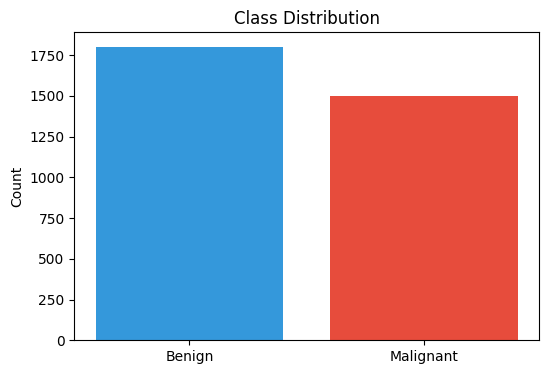

In [18]:
dataset = Data(device=device, img_size_w=224, img_size_h=224, up_sample=False)

In [19]:
num_images = 4
indices = random.sample(range(len(dataset.images)), num_images)

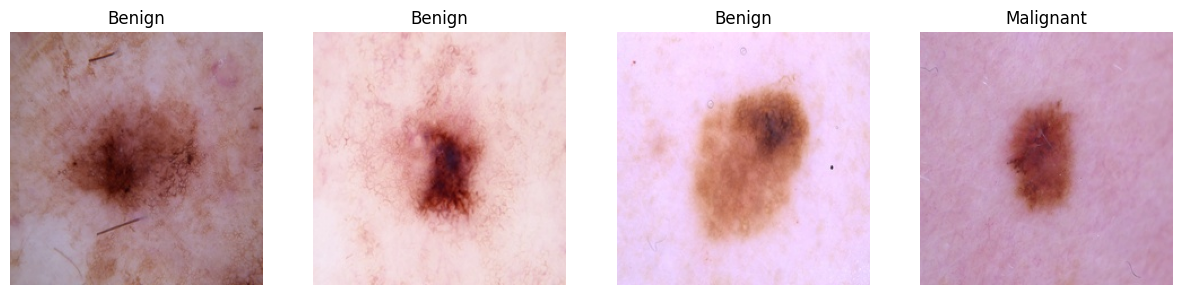

In [20]:
dataset.show_random_images(indices)

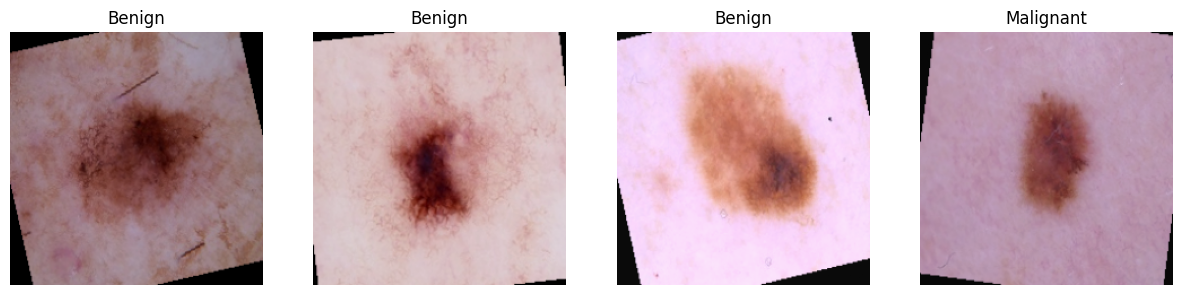

In [21]:
dataset.set_transformers(gn_train_transform, gn_val_transform)
dataset.visualize_augmentations(indices)

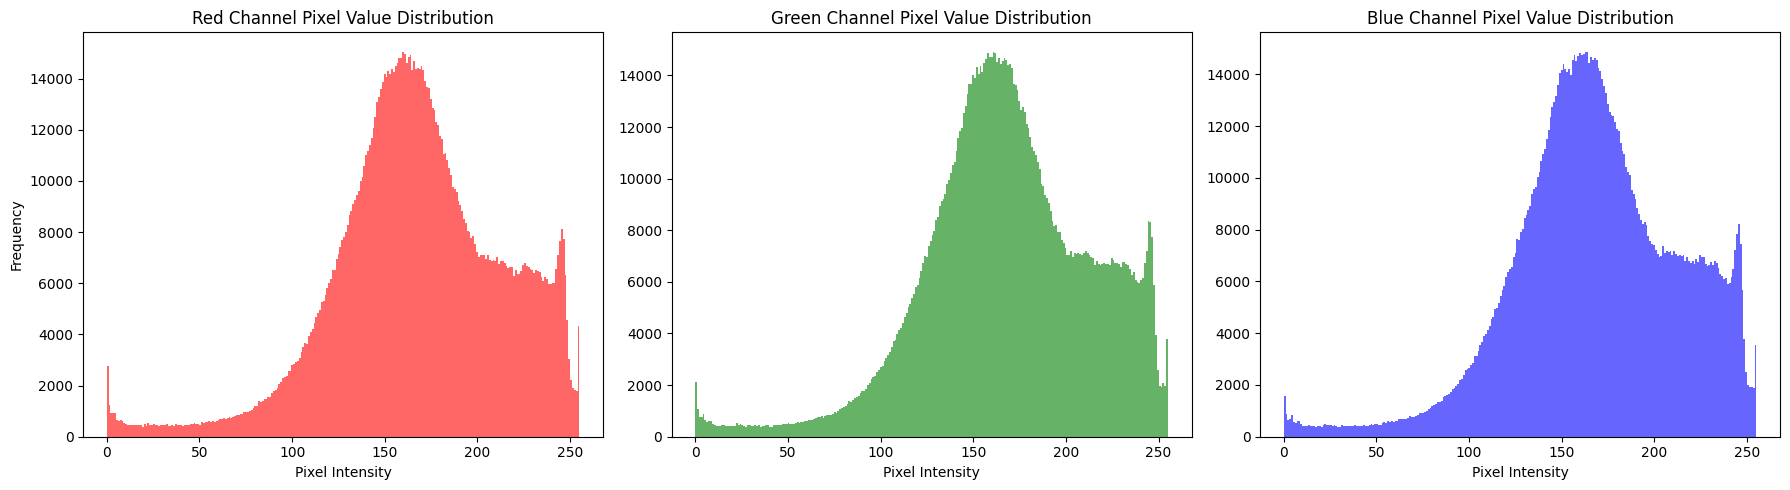

In [22]:
dataset.plot_color_channel_distribution()

## Train and Test SkinCancerCNN

dataset shape is : (1800, 28, 28, 3)
Class Distribution:
  Benign:    1800
  Malignant: 1800


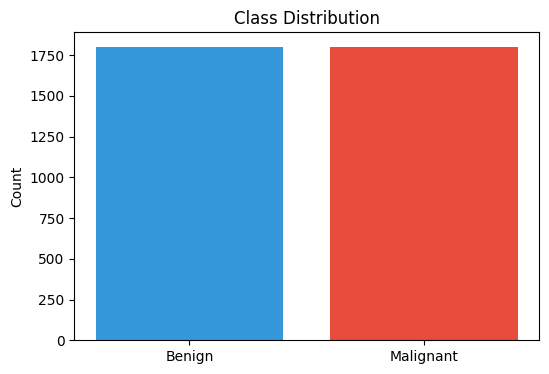

Train Loader Size: 36 batches
Val Loader Size: 9 batches
Test Loader Size: 12 batches


In [23]:
dataset1 = Data(device=device, img_size_w=28, img_size_h=28)
dataset1.set_transformers(train_transform, val_transform)
dataset1.normalize()

dataset1.set_mode('train')
train_loader1 = DataLoader(dataset1, batch_size=64, shuffle=True)
train_size1 = count_batches(train_loader1)

dataset1.set_mode('val')
val_loader1 = DataLoader(dataset1, batch_size=64, shuffle=False)
val_size1 = count_batches(val_loader1)

dataset1.set_mode('test')
test_loader1 = DataLoader(dataset1, batch_size=64, shuffle=False)
test_size1 = count_batches(test_loader1)

print(f"Train Loader Size: {train_size1} batches")
print(f"Val Loader Size: {val_size1} batches")
print(f"Test Loader Size: {test_size1} batches")

In [24]:
itr = next(iter(test_loader1))
# print(itr['image'])
# print(itr['label'])
test_images1, test_labels1 = itr['image'], itr['label']

In [25]:
model = SkinCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
train_acc, train_loss, val_acc, val_loss = train_model(model, optimizer, criterion, dataset1, train_loader1, val_loader1, num_epochs=model1_num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.88batch/s, accuracy=49, loss=0.673]


Training   Loss: 0.6890, Accuracy: 51.35%
Validation Loss: 0.6712, Accuracy: 48.96%
------------------------------ 

Epoch [2/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.11batch/s, accuracy=75.9, loss=0.552]


Training   Loss: 0.6237, Accuracy: 65.80%
Validation Loss: 0.5930, Accuracy: 75.87%
------------------------------ 

Epoch [3/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.27batch/s, accuracy=78, loss=0.462]


Training   Loss: 0.5477, Accuracy: 78.08%
Validation Loss: 0.5310, Accuracy: 77.95%
------------------------------ 

Epoch [4/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.32batch/s, accuracy=80.9, loss=0.37]


Training   Loss: 0.4605, Accuracy: 79.43%
Validation Loss: 0.4446, Accuracy: 80.90%
------------------------------ 

Epoch [5/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.10batch/s, accuracy=78.6, loss=0.399]


Training   Loss: 0.4369, Accuracy: 80.43%
Validation Loss: 0.4347, Accuracy: 78.65%
------------------------------ 

Epoch [6/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.13batch/s, accuracy=81.9, loss=0.366]


Training   Loss: 0.4310, Accuracy: 81.38%
Validation Loss: 0.4147, Accuracy: 81.94%
------------------------------ 

Epoch [7/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.69batch/s, accuracy=81.2, loss=0.369]


Training   Loss: 0.4242, Accuracy: 80.34%
Validation Loss: 0.4083, Accuracy: 81.25%
------------------------------ 

Epoch [8/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.88batch/s, accuracy=79.7, loss=0.346]


Training   Loss: 0.4244, Accuracy: 81.47%
Validation Loss: 0.4348, Accuracy: 79.69%
------------------------------ 

Epoch [9/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.81batch/s, accuracy=80, loss=0.381]


Training   Loss: 0.4193, Accuracy: 80.43%
Validation Loss: 0.4294, Accuracy: 80.03%
------------------------------ 

Epoch [10/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 14.65batch/s, accuracy=81.1, loss=0.354]


Training   Loss: 0.4323, Accuracy: 79.90%
Validation Loss: 0.4174, Accuracy: 81.08%
------------------------------ 

Epoch [11/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.03batch/s, accuracy=80.2, loss=0.374]


Training   Loss: 0.4148, Accuracy: 80.90%
Validation Loss: 0.4408, Accuracy: 80.21%
------------------------------ 

Epoch [12/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.13batch/s, accuracy=80.7, loss=0.364]


Training   Loss: 0.4197, Accuracy: 80.38%
Validation Loss: 0.4010, Accuracy: 80.73%
------------------------------ 

Epoch [13/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.68batch/s, accuracy=79.7, loss=0.378]


Training   Loss: 0.4103, Accuracy: 80.90%
Validation Loss: 0.4432, Accuracy: 79.69%
------------------------------ 

Epoch [14/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 18.36batch/s, accuracy=80.9, loss=0.359]


Training   Loss: 0.4215, Accuracy: 80.38%
Validation Loss: 0.4081, Accuracy: 80.90%
------------------------------ 

Epoch [15/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.89batch/s, accuracy=80, loss=0.337]


Training   Loss: 0.4149, Accuracy: 80.95%
Validation Loss: 0.4107, Accuracy: 80.03%
------------------------------ 

Epoch [16/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.26batch/s, accuracy=80.4, loss=0.326]


Training   Loss: 0.4008, Accuracy: 81.99%
Validation Loss: 0.4057, Accuracy: 80.38%
------------------------------ 

Epoch [17/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.09batch/s, accuracy=80.6, loss=0.343]


Training   Loss: 0.4092, Accuracy: 80.56%
Validation Loss: 0.4094, Accuracy: 80.56%
------------------------------ 

Epoch [18/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.68batch/s, accuracy=80.2, loss=0.342]


Training   Loss: 0.4026, Accuracy: 81.51%
Validation Loss: 0.4155, Accuracy: 80.21%
------------------------------ 

Epoch [19/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.22batch/s, accuracy=81.2, loss=0.339]


Training   Loss: 0.4000, Accuracy: 81.81%
Validation Loss: 0.3950, Accuracy: 81.25%
------------------------------ 

Epoch [20/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.43batch/s, accuracy=80.9, loss=0.346]


Training   Loss: 0.3987, Accuracy: 81.38%
Validation Loss: 0.3975, Accuracy: 80.90%
------------------------------ 

Epoch [21/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.89batch/s, accuracy=79.7, loss=0.334]


Training   Loss: 0.3914, Accuracy: 82.12%
Validation Loss: 0.4094, Accuracy: 79.69%
------------------------------ 

Epoch [22/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.77batch/s, accuracy=81.2, loss=0.31]


Training   Loss: 0.3863, Accuracy: 82.16%
Validation Loss: 0.3918, Accuracy: 81.25%
------------------------------ 

Epoch [23/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.01batch/s, accuracy=81.1, loss=0.312]


Training   Loss: 0.3878, Accuracy: 81.94%
Validation Loss: 0.3864, Accuracy: 81.08%
------------------------------ 

Epoch [24/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.32batch/s, accuracy=80, loss=0.3]


Training   Loss: 0.3880, Accuracy: 82.38%
Validation Loss: 0.3904, Accuracy: 80.03%
------------------------------ 

Epoch [25/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.14batch/s, accuracy=82.8, loss=0.326]


Training   Loss: 0.4099, Accuracy: 81.25%
Validation Loss: 0.3859, Accuracy: 82.81%
------------------------------ 

Epoch [26/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.74batch/s, accuracy=80.4, loss=0.312]


Training   Loss: 0.3991, Accuracy: 81.73%
Validation Loss: 0.3939, Accuracy: 80.38%
------------------------------ 

Epoch [27/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.08batch/s, accuracy=80.7, loss=0.3]


Training   Loss: 0.3992, Accuracy: 81.29%
Validation Loss: 0.3892, Accuracy: 80.73%
------------------------------ 

Epoch [28/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.01batch/s, accuracy=79.3, loss=0.339]


Training   Loss: 0.4013, Accuracy: 81.03%
Validation Loss: 0.4181, Accuracy: 79.34%
------------------------------ 

Epoch [29/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.51batch/s, accuracy=80.4, loss=0.3]


Training   Loss: 0.3867, Accuracy: 81.90%
Validation Loss: 0.4219, Accuracy: 80.38%
------------------------------ 

Epoch [30/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.97batch/s, accuracy=82.6, loss=0.299]


Training   Loss: 0.3760, Accuracy: 82.29%
Validation Loss: 0.3829, Accuracy: 82.64%
------------------------------ 

Epoch [31/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.21batch/s, accuracy=74.7, loss=0.422]


Training   Loss: 0.3798, Accuracy: 82.07%
Validation Loss: 0.5087, Accuracy: 74.65%
------------------------------ 

Epoch [32/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.98batch/s, accuracy=80, loss=0.297]


Training   Loss: 0.3831, Accuracy: 81.12%
Validation Loss: 0.3957, Accuracy: 80.03%
------------------------------ 

Epoch [33/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.31batch/s, accuracy=83, loss=0.293]


Training   Loss: 0.3704, Accuracy: 82.60%
Validation Loss: 0.3786, Accuracy: 82.99%
------------------------------ 

Epoch [34/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.80batch/s, accuracy=79.9, loss=0.298]


Training   Loss: 0.3670, Accuracy: 83.20%
Validation Loss: 0.4083, Accuracy: 79.86%
------------------------------ 

Epoch [35/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.53batch/s, accuracy=82.3, loss=0.303]


Training   Loss: 0.3785, Accuracy: 82.34%
Validation Loss: 0.3764, Accuracy: 82.29%
------------------------------ 

Epoch [36/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.06batch/s, accuracy=79.5, loss=0.319]


Training   Loss: 0.3657, Accuracy: 83.77%
Validation Loss: 0.4224, Accuracy: 79.51%
------------------------------ 

Epoch [37/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.85batch/s, accuracy=80, loss=0.302]


Training   Loss: 0.3688, Accuracy: 83.16%
Validation Loss: 0.4175, Accuracy: 80.03%
------------------------------ 

Epoch [38/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.90batch/s, accuracy=80.9, loss=0.269]


Training   Loss: 0.3583, Accuracy: 83.07%
Validation Loss: 0.3899, Accuracy: 80.90%
------------------------------ 

Epoch [39/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.17batch/s, accuracy=83, loss=0.281]


Training   Loss: 0.3540, Accuracy: 83.85%
Validation Loss: 0.3778, Accuracy: 82.99%
------------------------------ 

Epoch [40/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.29batch/s, accuracy=81.9, loss=0.266]


Training   Loss: 0.3658, Accuracy: 83.38%
Validation Loss: 0.3742, Accuracy: 81.94%
------------------------------ 

Epoch [41/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.42batch/s, accuracy=81.9, loss=0.269]


Training   Loss: 0.3673, Accuracy: 82.68%
Validation Loss: 0.3777, Accuracy: 81.94%
------------------------------ 

Epoch [42/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 18.43batch/s, accuracy=78.6, loss=0.344]


Training   Loss: 0.3688, Accuracy: 82.38%
Validation Loss: 0.4380, Accuracy: 78.65%
------------------------------ 

Epoch [43/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.63batch/s, accuracy=82.6, loss=0.286]


Training   Loss: 0.3628, Accuracy: 83.03%
Validation Loss: 0.3880, Accuracy: 82.64%
------------------------------ 

Epoch [44/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.65batch/s, accuracy=80.4, loss=0.288]


Training   Loss: 0.3534, Accuracy: 83.72%
Validation Loss: 0.4154, Accuracy: 80.38%
------------------------------ 

Epoch [45/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.62batch/s, accuracy=80.6, loss=0.283]


Training   Loss: 0.3657, Accuracy: 82.94%
Validation Loss: 0.4015, Accuracy: 80.56%
------------------------------ 

Epoch [46/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.57batch/s, accuracy=84, loss=0.255]


Training   Loss: 0.3530, Accuracy: 84.33%
Validation Loss: 0.3637, Accuracy: 84.03%
------------------------------ 

Epoch [47/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.59batch/s, accuracy=80.4, loss=0.321]


Training   Loss: 0.3547, Accuracy: 83.64%
Validation Loss: 0.4196, Accuracy: 80.38%
------------------------------ 

Epoch [48/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.60batch/s, accuracy=82.5, loss=0.26]


Training   Loss: 0.3538, Accuracy: 84.42%
Validation Loss: 0.3862, Accuracy: 82.47%
------------------------------ 

Epoch [49/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.47batch/s, accuracy=81.9, loss=0.281]


Training   Loss: 0.3492, Accuracy: 84.90%
Validation Loss: 0.3915, Accuracy: 81.94%
------------------------------ 

Epoch [50/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.43batch/s, accuracy=83.3, loss=0.242]


Training   Loss: 0.3521, Accuracy: 84.07%
Validation Loss: 0.3676, Accuracy: 83.33%
------------------------------ 

Epoch [51/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.03batch/s, accuracy=83.2, loss=0.252]


Training   Loss: 0.3518, Accuracy: 83.90%
Validation Loss: 0.3679, Accuracy: 83.16%
------------------------------ 

Epoch [52/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.85batch/s, accuracy=82.8, loss=0.264]


Training   Loss: 0.3438, Accuracy: 84.64%
Validation Loss: 0.3760, Accuracy: 82.81%
------------------------------ 

Epoch [53/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.22batch/s, accuracy=83.3, loss=0.253]


Training   Loss: 0.3412, Accuracy: 84.64%
Validation Loss: 0.3660, Accuracy: 83.33%
------------------------------ 

Epoch [54/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 19.36batch/s, accuracy=81.6, loss=0.249]


Training   Loss: 0.3470, Accuracy: 84.42%
Validation Loss: 0.3793, Accuracy: 81.60%
------------------------------ 

Epoch [55/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.10batch/s, accuracy=83, loss=0.244]


Training   Loss: 0.3459, Accuracy: 84.77%
Validation Loss: 0.3772, Accuracy: 82.99%
------------------------------ 

Epoch [56/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.20batch/s, accuracy=81.6, loss=0.266]


Training   Loss: 0.3439, Accuracy: 84.55%
Validation Loss: 0.3927, Accuracy: 81.60%
------------------------------ 

Epoch [57/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.41batch/s, accuracy=78.5, loss=0.339]


Training   Loss: 0.3448, Accuracy: 84.33%
Validation Loss: 0.4474, Accuracy: 78.47%
------------------------------ 

Epoch [58/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.66batch/s, accuracy=82.6, loss=0.249]


Training   Loss: 0.3528, Accuracy: 83.72%
Validation Loss: 0.3649, Accuracy: 82.64%
------------------------------ 

Epoch [59/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.63batch/s, accuracy=83, loss=0.234]


Training   Loss: 0.3389, Accuracy: 84.29%
Validation Loss: 0.3708, Accuracy: 82.99%
------------------------------ 

Epoch [60/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.61batch/s, accuracy=82.1, loss=0.23]


Training   Loss: 0.3562, Accuracy: 84.29%
Validation Loss: 0.3671, Accuracy: 82.12%
------------------------------ 

Epoch [61/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.69batch/s, accuracy=83.2, loss=0.242]


Training   Loss: 0.3558, Accuracy: 84.16%
Validation Loss: 0.3590, Accuracy: 83.16%
------------------------------ 

Epoch [62/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 19.08batch/s, accuracy=83.3, loss=0.235]


Training   Loss: 0.3406, Accuracy: 85.11%
Validation Loss: 0.3578, Accuracy: 83.33%
------------------------------ 

Epoch [63/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.15batch/s, accuracy=81.8, loss=0.255]


Training   Loss: 0.3349, Accuracy: 84.72%
Validation Loss: 0.3868, Accuracy: 81.77%
------------------------------ 

Epoch [64/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.88batch/s, accuracy=82.5, loss=0.243]


Training   Loss: 0.3502, Accuracy: 84.07%
Validation Loss: 0.3717, Accuracy: 82.47%
------------------------------ 

Epoch [65/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.45batch/s, accuracy=82.5, loss=0.228]


Training   Loss: 0.3379, Accuracy: 84.46%
Validation Loss: 0.3728, Accuracy: 82.47%
------------------------------ 

Epoch [66/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.96batch/s, accuracy=83.3, loss=0.25]


Training   Loss: 0.3416, Accuracy: 84.46%
Validation Loss: 0.3590, Accuracy: 83.33%
------------------------------ 

Epoch [67/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.47batch/s, accuracy=81.1, loss=0.248]


Training   Loss: 0.3314, Accuracy: 84.77%
Validation Loss: 0.3817, Accuracy: 81.08%
------------------------------ 

Epoch [68/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.95batch/s, accuracy=82.3, loss=0.23]


Training   Loss: 0.3479, Accuracy: 84.38%
Validation Loss: 0.3682, Accuracy: 82.29%
------------------------------ 

Epoch [69/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.33batch/s, accuracy=83.2, loss=0.233]


Training   Loss: 0.3419, Accuracy: 85.07%
Validation Loss: 0.3665, Accuracy: 83.16%
------------------------------ 

Epoch [70/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.66batch/s, accuracy=82.5, loss=0.234]


Training   Loss: 0.3294, Accuracy: 85.24%
Validation Loss: 0.3700, Accuracy: 82.47%
------------------------------ 

Epoch [71/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.12batch/s, accuracy=81.6, loss=0.235]


Training   Loss: 0.3282, Accuracy: 85.37%
Validation Loss: 0.3755, Accuracy: 81.60%
------------------------------ 

Epoch [72/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.79batch/s, accuracy=81.2, loss=0.239]


Training   Loss: 0.3258, Accuracy: 84.85%
Validation Loss: 0.3765, Accuracy: 81.25%
------------------------------ 

Epoch [73/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.84batch/s, accuracy=81.9, loss=0.237]


Training   Loss: 0.3255, Accuracy: 85.33%
Validation Loss: 0.3768, Accuracy: 81.94%
------------------------------ 

Epoch [74/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.83batch/s, accuracy=82.8, loss=0.231]


Training   Loss: 0.3276, Accuracy: 85.16%
Validation Loss: 0.3698, Accuracy: 82.81%
------------------------------ 

Epoch [75/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.11batch/s, accuracy=82.1, loss=0.237]


Training   Loss: 0.3244, Accuracy: 85.55%
Validation Loss: 0.3748, Accuracy: 82.12%
------------------------------ 

Epoch [76/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.01batch/s, accuracy=82.6, loss=0.226]


Training   Loss: 0.3247, Accuracy: 85.11%
Validation Loss: 0.3663, Accuracy: 82.64%
------------------------------ 

Epoch [77/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.57batch/s, accuracy=82.1, loss=0.223]


Training   Loss: 0.3253, Accuracy: 85.68%
Validation Loss: 0.3743, Accuracy: 82.12%
------------------------------ 

Epoch [78/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.91batch/s, accuracy=82.5, loss=0.234]


Training   Loss: 0.3198, Accuracy: 85.63%
Validation Loss: 0.3775, Accuracy: 82.47%
------------------------------ 

Epoch [79/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.67batch/s, accuracy=82.1, loss=0.237]


Training   Loss: 0.3268, Accuracy: 84.90%
Validation Loss: 0.3746, Accuracy: 82.12%
------------------------------ 

Epoch [80/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.63batch/s, accuracy=81.2, loss=0.251]


Training   Loss: 0.3243, Accuracy: 85.29%
Validation Loss: 0.3917, Accuracy: 81.25%
------------------------------ 

Epoch [81/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.92batch/s, accuracy=82.3, loss=0.231]


Training   Loss: 0.3216, Accuracy: 85.33%
Validation Loss: 0.3708, Accuracy: 82.29%
------------------------------ 

Epoch [82/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.78batch/s, accuracy=82.8, loss=0.222]


Training   Loss: 0.3225, Accuracy: 85.55%
Validation Loss: 0.3737, Accuracy: 82.81%
------------------------------ 

Epoch [83/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.28batch/s, accuracy=82.3, loss=0.225]


Training   Loss: 0.3242, Accuracy: 85.37%
Validation Loss: 0.3710, Accuracy: 82.29%
------------------------------ 

Epoch [84/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.55batch/s, accuracy=81.9, loss=0.235]


Training   Loss: 0.3210, Accuracy: 85.07%
Validation Loss: 0.3786, Accuracy: 81.94%
------------------------------ 

Epoch [85/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.79batch/s, accuracy=82.5, loss=0.23]


Training   Loss: 0.3229, Accuracy: 85.20%
Validation Loss: 0.3717, Accuracy: 82.47%
------------------------------ 

Epoch [86/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.98batch/s, accuracy=82.3, loss=0.236]


Training   Loss: 0.3219, Accuracy: 85.55%
Validation Loss: 0.3759, Accuracy: 82.29%
------------------------------ 

Epoch [87/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.54batch/s, accuracy=82.5, loss=0.235]


Training   Loss: 0.3181, Accuracy: 85.59%
Validation Loss: 0.3747, Accuracy: 82.47%
------------------------------ 

Epoch [88/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.24batch/s, accuracy=82.5, loss=0.233]


Training   Loss: 0.3259, Accuracy: 85.42%
Validation Loss: 0.3727, Accuracy: 82.47%
------------------------------ 

Epoch [89/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.13batch/s, accuracy=82.5, loss=0.231]


Training   Loss: 0.3257, Accuracy: 85.63%
Validation Loss: 0.3739, Accuracy: 82.47%
------------------------------ 

Epoch [90/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.68batch/s, accuracy=82.1, loss=0.228]


Training   Loss: 0.3210, Accuracy: 85.94%
Validation Loss: 0.3737, Accuracy: 82.12%
------------------------------ 

Epoch [91/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.54batch/s, accuracy=81.8, loss=0.224]


Training   Loss: 0.3187, Accuracy: 85.89%
Validation Loss: 0.3767, Accuracy: 81.77%
------------------------------ 

Epoch [92/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.71batch/s, accuracy=81.9, loss=0.226]


Training   Loss: 0.3200, Accuracy: 85.07%
Validation Loss: 0.3745, Accuracy: 81.94%
------------------------------ 

Epoch [93/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.75batch/s, accuracy=82.1, loss=0.233]


Training   Loss: 0.3308, Accuracy: 85.16%
Validation Loss: 0.3795, Accuracy: 82.12%
------------------------------ 

Epoch [94/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.33batch/s, accuracy=81.8, loss=0.234]


Training   Loss: 0.3204, Accuracy: 85.63%
Validation Loss: 0.3677, Accuracy: 81.77%
------------------------------ 

Epoch [95/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.99batch/s, accuracy=82.5, loss=0.233]


Training   Loss: 0.3201, Accuracy: 85.89%
Validation Loss: 0.3677, Accuracy: 82.47%
------------------------------ 

Epoch [96/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.11batch/s, accuracy=81.9, loss=0.227]


Training   Loss: 0.3249, Accuracy: 85.55%
Validation Loss: 0.3761, Accuracy: 81.94%
------------------------------ 

Epoch [97/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.38batch/s, accuracy=83, loss=0.226]


Training   Loss: 0.3202, Accuracy: 85.63%
Validation Loss: 0.3661, Accuracy: 82.99%
------------------------------ 

Epoch [98/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.90batch/s, accuracy=82.6, loss=0.226]


Training   Loss: 0.3220, Accuracy: 85.16%
Validation Loss: 0.3708, Accuracy: 82.64%
------------------------------ 

Epoch [99/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.37batch/s, accuracy=82.6, loss=0.227]


Training   Loss: 0.3252, Accuracy: 85.50%
Validation Loss: 0.3690, Accuracy: 82.64%
------------------------------ 

Epoch [100/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.73batch/s, accuracy=81.9, loss=0.23]

Training   Loss: 0.3193, Accuracy: 85.24%
Validation Loss: 0.3778, Accuracy: 81.94%
------------------------------ 



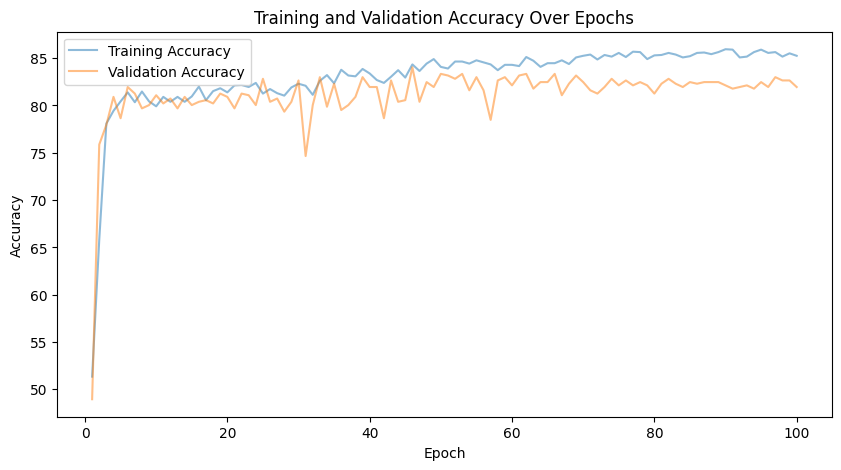

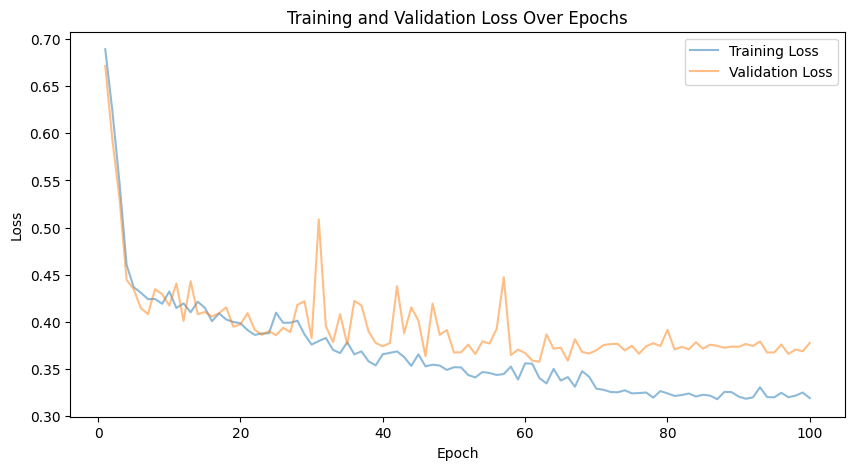

In [27]:
plot_metric('Accuracy', train_acc, val_acc, epochs=model1_num_epochs)
plot_metric('Loss', train_loss, val_loss, epochs=model1_num_epochs)

In [28]:
test_loss, test_acc, y_true, y_probs = eval_model(model, criterion, dataset1, test_loader1, 'test')
print(f'test loss = {test_loss}')
print(f'test acc = {test_acc}')

Validation: 100%|██████████| 12/12 [00:00<00:00, 21.64batch/s, accuracy=81.8, loss=0.144]

test loss = 0.3477977278331916
test acc = 81.80555555555556


[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0,

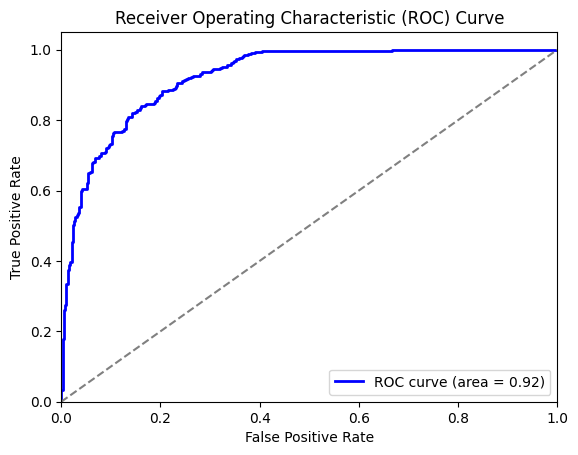

In [30]:
plot_roc_curve(y_true, y_probs)

## Train and Test improvedModel

dataset shape is : (1800, 28, 28, 3)
Class Distribution:
  Benign:    1800
  Malignant: 1800


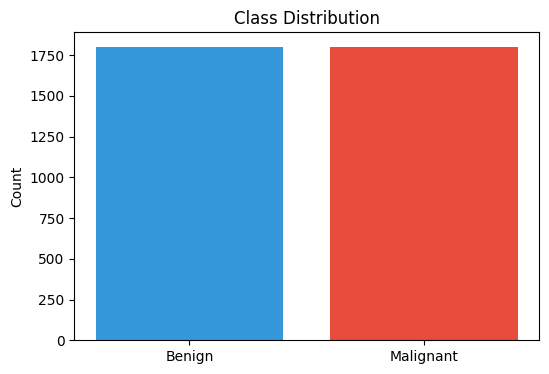

Train Loader Size: 36 batches
Val Loader Size: 9 batches
Test Loader Size: 12 batches


In [31]:
dataset2 = Data(device=device, img_size_w=28, img_size_h=28)
dataset2.set_transformers(train_transform, val_transform)
dataset2.normalize()

dataset2.set_mode('train')
train_loader2 = DataLoader(dataset2, batch_size=64, shuffle=True)
train_size2 = count_batches(train_loader2)

dataset2.set_mode('val')
val_loader2 = DataLoader(dataset2, batch_size=64, shuffle=False)
val_size2 = count_batches(val_loader2)

dataset2.set_mode('test')
test_loader2 = DataLoader(dataset2, batch_size=64, shuffle=False)
test_size2 = count_batches(test_loader2)

print(f"Train Loader Size: {train_size2} batches")
print(f"Val Loader Size: {val_size2} batches")
print(f"Test Loader Size: {test_size2} batches")

In [32]:
improvedModel = ImprovedSkinCancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improvedModel.parameters(), lr=learning_rate)
train_acc, train_loss, val_acc, val_loss = train_model(improvedModel, optimizer, criterion, dataset2, train_loader2, val_loader2, num_epochs=model2_num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.66batch/s, accuracy=61.8, loss=0.6]


Training   Loss: 0.5609, Accuracy: 71.44%
Validation Loss: 0.6171, Accuracy: 61.81%
------------------------------ 

Epoch [2/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.06batch/s, accuracy=77.6, loss=0.466]


Training   Loss: 0.4674, Accuracy: 78.12%
Validation Loss: 0.4618, Accuracy: 77.60%
------------------------------ 

Epoch [3/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.63batch/s, accuracy=78.5, loss=0.447]


Training   Loss: 0.4179, Accuracy: 80.90%
Validation Loss: 0.4606, Accuracy: 78.47%
------------------------------ 

Epoch [4/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.60batch/s, accuracy=81.4, loss=0.347]


Training   Loss: 0.4087, Accuracy: 81.08%
Validation Loss: 0.3779, Accuracy: 81.42%
------------------------------ 

Epoch [5/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.91batch/s, accuracy=83.7, loss=0.374]


Training   Loss: 0.3878, Accuracy: 81.38%
Validation Loss: 0.3961, Accuracy: 83.68%
------------------------------ 

Epoch [6/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.77batch/s, accuracy=81.1, loss=0.306]


Training   Loss: 0.3781, Accuracy: 82.55%
Validation Loss: 0.3691, Accuracy: 81.08%
------------------------------ 

Epoch [7/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 18.21batch/s, accuracy=82.1, loss=0.345]


Training   Loss: 0.3695, Accuracy: 82.81%
Validation Loss: 0.3952, Accuracy: 82.12%
------------------------------ 

Epoch [8/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.10batch/s, accuracy=83.9, loss=0.311]


Training   Loss: 0.3717, Accuracy: 83.38%
Validation Loss: 0.3643, Accuracy: 83.85%
------------------------------ 

Epoch [9/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.80batch/s, accuracy=82.8, loss=0.255]


Training   Loss: 0.3689, Accuracy: 82.55%
Validation Loss: 0.3622, Accuracy: 82.81%
------------------------------ 

Epoch [10/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.38batch/s, accuracy=83, loss=0.261]


Training   Loss: 0.3699, Accuracy: 83.25%
Validation Loss: 0.3674, Accuracy: 82.99%
------------------------------ 

Epoch [11/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.98batch/s, accuracy=83.5, loss=0.256]


Training   Loss: 0.3577, Accuracy: 83.55%
Validation Loss: 0.3657, Accuracy: 83.51%
------------------------------ 

Epoch [12/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.98batch/s, accuracy=84.4, loss=0.28]


Training   Loss: 0.3566, Accuracy: 83.07%
Validation Loss: 0.3720, Accuracy: 84.38%
------------------------------ 

Epoch [13/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.38batch/s, accuracy=82.8, loss=0.245]


Training   Loss: 0.3541, Accuracy: 83.81%
Validation Loss: 0.3537, Accuracy: 82.81%
------------------------------ 

Epoch [14/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.76batch/s, accuracy=83.9, loss=0.256]


Training   Loss: 0.3638, Accuracy: 82.86%
Validation Loss: 0.3627, Accuracy: 83.85%
------------------------------ 

Epoch [15/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.43batch/s, accuracy=83.2, loss=0.244]


Training   Loss: 0.3420, Accuracy: 83.64%
Validation Loss: 0.3562, Accuracy: 83.16%
------------------------------ 

Epoch [16/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.45batch/s, accuracy=82.8, loss=0.23]


Training   Loss: 0.3406, Accuracy: 83.98%
Validation Loss: 0.3620, Accuracy: 82.81%
------------------------------ 

Epoch [17/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.98batch/s, accuracy=83.9, loss=0.262]


Training   Loss: 0.3500, Accuracy: 83.77%
Validation Loss: 0.3624, Accuracy: 83.85%
------------------------------ 

Epoch [18/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.46batch/s, accuracy=84.2, loss=0.254]


Training   Loss: 0.3401, Accuracy: 84.55%
Validation Loss: 0.3559, Accuracy: 84.20%
------------------------------ 

Epoch [19/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.63batch/s, accuracy=82.3, loss=0.227]


Training   Loss: 0.3423, Accuracy: 84.46%
Validation Loss: 0.3611, Accuracy: 82.29%
------------------------------ 

Epoch [20/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.90batch/s, accuracy=85.1, loss=0.232]


Training   Loss: 0.3342, Accuracy: 85.20%
Validation Loss: 0.3450, Accuracy: 85.07%
------------------------------ 

Epoch [21/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.10batch/s, accuracy=79.3, loss=0.328]


Training   Loss: 0.3285, Accuracy: 84.64%
Validation Loss: 0.4085, Accuracy: 79.34%
------------------------------ 

Epoch [22/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.39batch/s, accuracy=82.6, loss=0.264]


Training   Loss: 0.3220, Accuracy: 85.37%
Validation Loss: 0.3590, Accuracy: 82.64%
------------------------------ 

Epoch [23/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.96batch/s, accuracy=82.1, loss=0.21]


Training   Loss: 0.3253, Accuracy: 84.90%
Validation Loss: 0.3782, Accuracy: 82.12%
------------------------------ 

Epoch [24/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.43batch/s, accuracy=81.2, loss=0.248]


Training   Loss: 0.3182, Accuracy: 85.33%
Validation Loss: 0.3566, Accuracy: 81.25%
------------------------------ 

Epoch [25/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.18batch/s, accuracy=82.6, loss=0.247]


Training   Loss: 0.3264, Accuracy: 84.85%
Validation Loss: 0.3655, Accuracy: 82.64%
------------------------------ 

Epoch [26/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.04batch/s, accuracy=82.6, loss=0.249]


Training   Loss: 0.3324, Accuracy: 84.55%
Validation Loss: 0.3493, Accuracy: 82.64%
------------------------------ 

Epoch [27/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.72batch/s, accuracy=80.9, loss=0.29]


Training   Loss: 0.3232, Accuracy: 84.81%
Validation Loss: 0.3780, Accuracy: 80.90%
------------------------------ 

Epoch [28/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.95batch/s, accuracy=83, loss=0.266]


Training   Loss: 0.3134, Accuracy: 85.07%
Validation Loss: 0.3426, Accuracy: 82.99%
------------------------------ 

Epoch [29/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.92batch/s, accuracy=82.5, loss=0.232]


Training   Loss: 0.3326, Accuracy: 85.33%
Validation Loss: 0.3539, Accuracy: 82.47%
------------------------------ 

Epoch [30/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.24batch/s, accuracy=82.8, loss=0.24]


Training   Loss: 0.3237, Accuracy: 85.59%
Validation Loss: 0.3402, Accuracy: 82.81%
------------------------------ 

Epoch [31/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.92batch/s, accuracy=84.2, loss=0.257]


Training   Loss: 0.3176, Accuracy: 84.38%
Validation Loss: 0.3499, Accuracy: 84.20%
------------------------------ 

Epoch [32/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.99batch/s, accuracy=80.4, loss=0.321]


Training   Loss: 0.3135, Accuracy: 85.11%
Validation Loss: 0.4012, Accuracy: 80.38%
------------------------------ 

Epoch [33/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.65batch/s, accuracy=84.5, loss=0.254]


Training   Loss: 0.3141, Accuracy: 85.59%
Validation Loss: 0.3317, Accuracy: 84.55%
------------------------------ 

Epoch [34/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.46batch/s, accuracy=82.8, loss=0.233]


Training   Loss: 0.3120, Accuracy: 85.55%
Validation Loss: 0.3343, Accuracy: 82.81%
------------------------------ 

Epoch [35/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.36batch/s, accuracy=82.8, loss=0.239]


Training   Loss: 0.3157, Accuracy: 85.03%
Validation Loss: 0.3280, Accuracy: 82.81%
------------------------------ 

Epoch [36/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.44batch/s, accuracy=81.9, loss=0.255]


Training   Loss: 0.3127, Accuracy: 86.24%
Validation Loss: 0.3494, Accuracy: 81.94%
------------------------------ 

Epoch [37/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.23batch/s, accuracy=83.7, loss=0.257]


Training   Loss: 0.3033, Accuracy: 85.72%
Validation Loss: 0.3401, Accuracy: 83.68%
------------------------------ 

Epoch [38/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.74batch/s, accuracy=81.2, loss=0.244]


Training   Loss: 0.3051, Accuracy: 85.42%
Validation Loss: 0.3839, Accuracy: 81.25%
------------------------------ 

Epoch [39/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.82batch/s, accuracy=83.2, loss=0.256]


Training   Loss: 0.3050, Accuracy: 86.20%
Validation Loss: 0.3364, Accuracy: 83.16%
------------------------------ 

Epoch [40/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.02batch/s, accuracy=81.2, loss=0.29]


Training   Loss: 0.3038, Accuracy: 85.85%
Validation Loss: 0.3651, Accuracy: 81.25%
------------------------------ 

Epoch [41/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.34batch/s, accuracy=83, loss=0.287]


Training   Loss: 0.3048, Accuracy: 86.28%
Validation Loss: 0.3544, Accuracy: 82.99%
------------------------------ 

Epoch [42/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.72batch/s, accuracy=82.5, loss=0.249]


Training   Loss: 0.2950, Accuracy: 85.81%
Validation Loss: 0.3387, Accuracy: 82.47%
------------------------------ 

Epoch [43/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.20batch/s, accuracy=81.8, loss=0.249]


Training   Loss: 0.2869, Accuracy: 86.89%
Validation Loss: 0.3530, Accuracy: 81.77%
------------------------------ 

Epoch [44/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.38batch/s, accuracy=84.2, loss=0.257]


Training   Loss: 0.2945, Accuracy: 85.94%
Validation Loss: 0.3284, Accuracy: 84.20%
------------------------------ 

Epoch [45/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.13batch/s, accuracy=82.5, loss=0.232]


Training   Loss: 0.2905, Accuracy: 86.33%
Validation Loss: 0.3388, Accuracy: 82.47%
------------------------------ 

Epoch [46/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.88batch/s, accuracy=83.3, loss=0.26]


Training   Loss: 0.2866, Accuracy: 87.20%
Validation Loss: 0.3292, Accuracy: 83.33%
------------------------------ 

Epoch [47/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.01batch/s, accuracy=83, loss=0.264]


Training   Loss: 0.2924, Accuracy: 86.15%
Validation Loss: 0.3382, Accuracy: 82.99%
------------------------------ 

Epoch [48/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 19.99batch/s, accuracy=83.5, loss=0.258]


Training   Loss: 0.3054, Accuracy: 85.72%
Validation Loss: 0.3243, Accuracy: 83.51%
------------------------------ 

Epoch [49/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.88batch/s, accuracy=82.8, loss=0.255]


Training   Loss: 0.2763, Accuracy: 87.28%
Validation Loss: 0.3363, Accuracy: 82.81%
------------------------------ 

Epoch [50/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.19batch/s, accuracy=84.5, loss=0.27]


Training   Loss: 0.2854, Accuracy: 86.98%
Validation Loss: 0.3418, Accuracy: 84.55%
------------------------------ 

Epoch [51/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.35batch/s, accuracy=83, loss=0.291]


Training   Loss: 0.2862, Accuracy: 86.37%
Validation Loss: 0.3557, Accuracy: 82.99%
------------------------------ 

Epoch [52/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.42batch/s, accuracy=82.5, loss=0.209]


Training   Loss: 0.2890, Accuracy: 87.50%
Validation Loss: 0.3460, Accuracy: 82.47%
------------------------------ 

Epoch [53/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.79batch/s, accuracy=83.9, loss=0.213]


Training   Loss: 0.2835, Accuracy: 87.02%
Validation Loss: 0.3150, Accuracy: 83.85%
------------------------------ 

Epoch [54/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.95batch/s, accuracy=85.1, loss=0.244]


Training   Loss: 0.2801, Accuracy: 87.02%
Validation Loss: 0.3220, Accuracy: 85.07%
------------------------------ 

Epoch [55/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.44batch/s, accuracy=79.9, loss=0.35]


Training   Loss: 0.2878, Accuracy: 86.55%
Validation Loss: 0.3814, Accuracy: 79.86%
------------------------------ 

Epoch [56/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.15batch/s, accuracy=83.3, loss=0.276]


Training   Loss: 0.2785, Accuracy: 86.94%
Validation Loss: 0.3424, Accuracy: 83.33%
------------------------------ 

Epoch [57/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.39batch/s, accuracy=82.8, loss=0.263]


Training   Loss: 0.2925, Accuracy: 87.02%
Validation Loss: 0.3315, Accuracy: 82.81%
------------------------------ 

Epoch [58/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.78batch/s, accuracy=84.2, loss=0.244]


Training   Loss: 0.2775, Accuracy: 87.11%
Validation Loss: 0.3192, Accuracy: 84.20%
------------------------------ 

Epoch [59/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.69batch/s, accuracy=84.7, loss=0.285]


Training   Loss: 0.2660, Accuracy: 88.11%
Validation Loss: 0.3236, Accuracy: 84.72%
------------------------------ 

Epoch [60/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.17batch/s, accuracy=81.1, loss=0.342]


Training   Loss: 0.2689, Accuracy: 87.63%
Validation Loss: 0.3699, Accuracy: 81.08%
------------------------------ 

Epoch [61/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.22batch/s, accuracy=84.2, loss=0.24]


Training   Loss: 0.2751, Accuracy: 87.28%
Validation Loss: 0.3104, Accuracy: 84.20%
------------------------------ 

Epoch [62/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.39batch/s, accuracy=85.2, loss=0.236]


Training   Loss: 0.2676, Accuracy: 87.46%
Validation Loss: 0.3054, Accuracy: 85.24%
------------------------------ 

Epoch [63/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.68batch/s, accuracy=82.5, loss=0.342]


Training   Loss: 0.2805, Accuracy: 86.72%
Validation Loss: 0.3505, Accuracy: 82.47%
------------------------------ 

Epoch [64/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.90batch/s, accuracy=82.8, loss=0.247]


Training   Loss: 0.2612, Accuracy: 87.85%
Validation Loss: 0.3232, Accuracy: 82.81%
------------------------------ 

Epoch [65/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.71batch/s, accuracy=84.9, loss=0.228]


Training   Loss: 0.2891, Accuracy: 86.50%
Validation Loss: 0.3104, Accuracy: 84.90%
------------------------------ 

Epoch [66/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.44batch/s, accuracy=83, loss=0.212]


Training   Loss: 0.2644, Accuracy: 87.76%
Validation Loss: 0.3247, Accuracy: 82.99%
------------------------------ 

Epoch [67/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.78batch/s, accuracy=84.9, loss=0.296]


Training   Loss: 0.2714, Accuracy: 87.72%
Validation Loss: 0.3249, Accuracy: 84.90%
------------------------------ 

Epoch [68/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.77batch/s, accuracy=83, loss=0.269]


Training   Loss: 0.2657, Accuracy: 87.63%
Validation Loss: 0.3266, Accuracy: 82.99%
------------------------------ 

Epoch [69/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.65batch/s, accuracy=83, loss=0.258]


Training   Loss: 0.2638, Accuracy: 86.98%
Validation Loss: 0.3242, Accuracy: 82.99%
------------------------------ 

Epoch [70/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.55batch/s, accuracy=80.9, loss=0.317]


Training   Loss: 0.2604, Accuracy: 87.41%
Validation Loss: 0.3775, Accuracy: 80.90%
------------------------------ 

Epoch [71/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.01batch/s, accuracy=84.7, loss=0.197]


Training   Loss: 0.2631, Accuracy: 87.67%
Validation Loss: 0.3086, Accuracy: 84.72%
------------------------------ 

Epoch [72/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.76batch/s, accuracy=84.2, loss=0.226]


Training   Loss: 0.2666, Accuracy: 87.93%
Validation Loss: 0.3115, Accuracy: 84.20%
------------------------------ 

Epoch [73/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.13batch/s, accuracy=83.7, loss=0.246]


Training   Loss: 0.2650, Accuracy: 87.54%
Validation Loss: 0.3235, Accuracy: 83.68%
------------------------------ 

Epoch [74/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.64batch/s, accuracy=85.6, loss=0.221]


Training   Loss: 0.2810, Accuracy: 87.28%
Validation Loss: 0.3001, Accuracy: 85.59%
------------------------------ 

Epoch [75/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.57batch/s, accuracy=84.7, loss=0.229]


Training   Loss: 0.2784, Accuracy: 87.80%
Validation Loss: 0.3182, Accuracy: 84.72%
------------------------------ 

Epoch [76/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.22batch/s, accuracy=85.1, loss=0.269]


Training   Loss: 0.2658, Accuracy: 87.59%
Validation Loss: 0.3213, Accuracy: 85.07%
------------------------------ 

Epoch [77/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.03batch/s, accuracy=86.1, loss=0.224]


Training   Loss: 0.2573, Accuracy: 88.63%
Validation Loss: 0.3034, Accuracy: 86.11%
------------------------------ 

Epoch [78/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.28batch/s, accuracy=84.9, loss=0.26]


Training   Loss: 0.2578, Accuracy: 88.54%
Validation Loss: 0.3068, Accuracy: 84.90%
------------------------------ 

Epoch [79/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.16batch/s, accuracy=87.2, loss=0.234]


Training   Loss: 0.2463, Accuracy: 88.72%
Validation Loss: 0.2993, Accuracy: 87.15%
------------------------------ 

Epoch [80/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.73batch/s, accuracy=85.6, loss=0.243]


Training   Loss: 0.2421, Accuracy: 88.85%
Validation Loss: 0.2982, Accuracy: 85.59%
------------------------------ 

Epoch [81/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.77batch/s, accuracy=85.9, loss=0.221]


Training   Loss: 0.2431, Accuracy: 88.76%
Validation Loss: 0.2960, Accuracy: 85.94%
------------------------------ 

Epoch [82/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.43batch/s, accuracy=85.4, loss=0.239]


Training   Loss: 0.2534, Accuracy: 88.37%
Validation Loss: 0.3001, Accuracy: 85.42%
------------------------------ 

Epoch [83/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.20batch/s, accuracy=85.9, loss=0.231]


Training   Loss: 0.2360, Accuracy: 88.93%
Validation Loss: 0.3037, Accuracy: 85.94%
------------------------------ 

Epoch [84/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.94batch/s, accuracy=85.2, loss=0.228]


Training   Loss: 0.2503, Accuracy: 88.54%
Validation Loss: 0.2987, Accuracy: 85.24%
------------------------------ 

Epoch [85/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.61batch/s, accuracy=87.8, loss=0.222]


Training   Loss: 0.2405, Accuracy: 89.11%
Validation Loss: 0.2922, Accuracy: 87.85%
------------------------------ 

Epoch [86/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.29batch/s, accuracy=85.2, loss=0.246]


Training   Loss: 0.2559, Accuracy: 88.37%
Validation Loss: 0.2944, Accuracy: 85.24%
------------------------------ 

Epoch [87/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.74batch/s, accuracy=85.9, loss=0.25]


Training   Loss: 0.2538, Accuracy: 88.63%
Validation Loss: 0.2985, Accuracy: 85.94%
------------------------------ 

Epoch [88/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.35batch/s, accuracy=85.4, loss=0.216]


Training   Loss: 0.2495, Accuracy: 89.02%
Validation Loss: 0.2982, Accuracy: 85.42%
------------------------------ 

Epoch [89/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.79batch/s, accuracy=84.9, loss=0.226]


Training   Loss: 0.2467, Accuracy: 89.24%
Validation Loss: 0.3050, Accuracy: 84.90%
------------------------------ 

Epoch [90/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.46batch/s, accuracy=86.8, loss=0.208]


Training   Loss: 0.2458, Accuracy: 89.02%
Validation Loss: 0.2998, Accuracy: 86.81%
------------------------------ 

Epoch [91/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.91batch/s, accuracy=85.4, loss=0.231]


Training   Loss: 0.2462, Accuracy: 88.72%
Validation Loss: 0.3049, Accuracy: 85.42%
------------------------------ 

Epoch [92/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.86batch/s, accuracy=85.9, loss=0.226]


Training   Loss: 0.2353, Accuracy: 90.10%
Validation Loss: 0.2967, Accuracy: 85.94%
------------------------------ 

Epoch [93/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.01batch/s, accuracy=86.5, loss=0.231]


Training   Loss: 0.2516, Accuracy: 88.80%
Validation Loss: 0.3036, Accuracy: 86.46%
------------------------------ 

Epoch [94/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.82batch/s, accuracy=85.4, loss=0.237]


Training   Loss: 0.2477, Accuracy: 89.45%
Validation Loss: 0.3150, Accuracy: 85.42%
------------------------------ 

Epoch [95/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.94batch/s, accuracy=85.2, loss=0.209]


Training   Loss: 0.2445, Accuracy: 88.93%
Validation Loss: 0.2971, Accuracy: 85.24%
------------------------------ 

Epoch [96/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.54batch/s, accuracy=86.1, loss=0.222]


Training   Loss: 0.2385, Accuracy: 89.67%
Validation Loss: 0.3055, Accuracy: 86.11%
------------------------------ 

Epoch [97/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.69batch/s, accuracy=86.1, loss=0.232]


Training   Loss: 0.2520, Accuracy: 88.54%
Validation Loss: 0.2987, Accuracy: 86.11%
------------------------------ 

Epoch [98/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.82batch/s, accuracy=86.8, loss=0.231]


Training   Loss: 0.2371, Accuracy: 89.19%
Validation Loss: 0.2972, Accuracy: 86.81%
------------------------------ 

Epoch [99/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.54batch/s, accuracy=84.7, loss=0.253]


Training   Loss: 0.2373, Accuracy: 89.06%
Validation Loss: 0.3030, Accuracy: 84.72%
------------------------------ 

Epoch [100/100]


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.67batch/s, accuracy=86.1, loss=0.211]

Training   Loss: 0.2420, Accuracy: 88.98%
Validation Loss: 0.3020, Accuracy: 86.11%
------------------------------ 



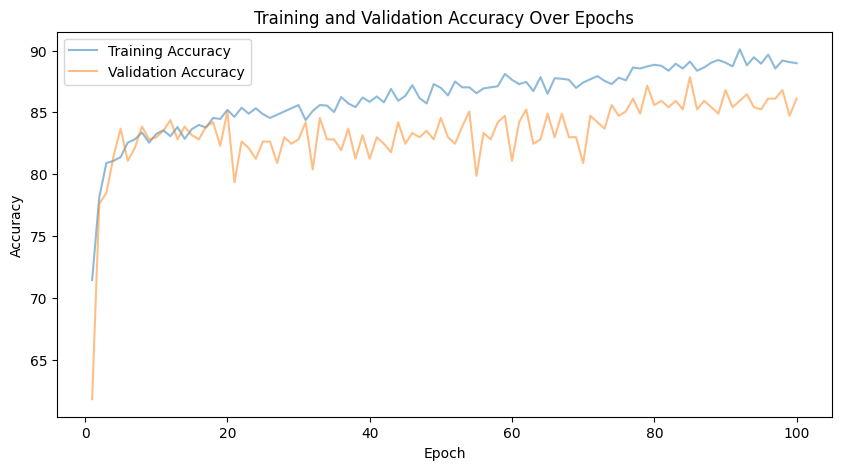

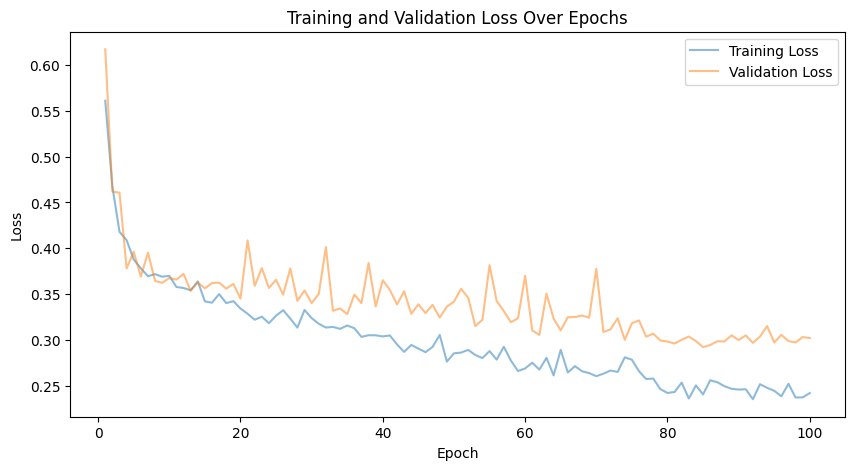

In [33]:
plot_metric('Accuracy', train_acc, val_acc, epochs=model2_num_epochs)
plot_metric('Loss', train_loss, val_loss, epochs=model2_num_epochs)

In [34]:
test_loss, test_acc, y_true, y_probs = eval_model(improvedModel, criterion, dataset2, test_loader2, 'test')
print(f'test loss = {test_loss}')
print(f'test acc = {test_acc}')

Validation: 100%|██████████| 12/12 [00:00<00:00, 25.18batch/s, accuracy=85.7, loss=0.173]

test loss = 0.28268249829610187
test acc = 85.69444444444444


[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0,

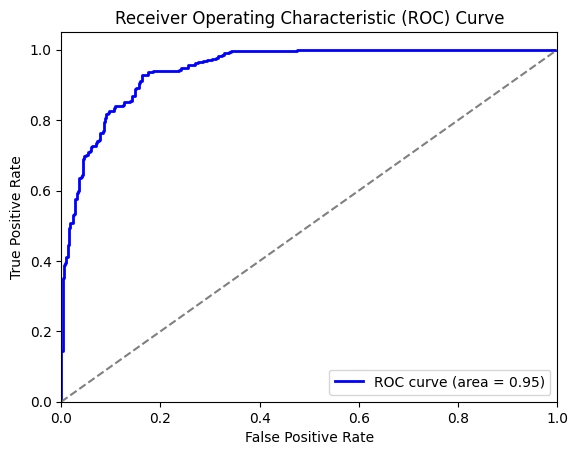

In [35]:
plot_roc_curve(y_true, y_probs)

## Train and Test GoogLeNet

dataset shape is : (1800, 224, 224, 3)
Class Distribution:
  Benign:    1800
  Malignant: 1800


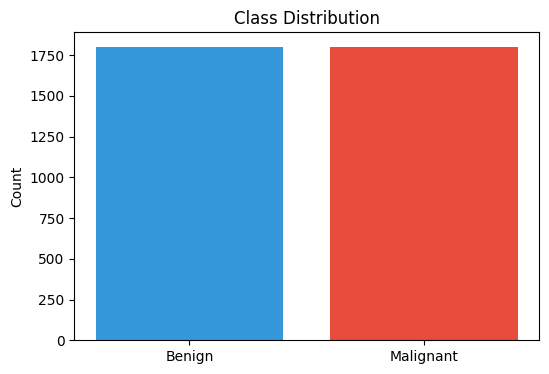

In [36]:
gn_dataset = Data(device=device)
gn_dataset.set_transformers(gn_train_transform, gn_val_transform)
gn_dataset.normalize()

gn_dataset.set_mode('train')
gn_train_loader = DataLoader(gn_dataset, batch_size=64, shuffle=True)

gn_dataset.set_mode('val')
gn_val_loader = DataLoader(gn_dataset, batch_size=64, shuffle=False)

gn_dataset.set_mode('test')
gn_test_loader = DataLoader(gn_dataset, batch_size=64, shuffle=False)

In [37]:
gn_model = GoogLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gn_model.parameters(), lr=learning_rate) # , weight_decay=0.001
train_acc, train_loss, val_acc, val_loss = train_with_GoogleNet_model(gn_model, optimizer, criterion, gn_dataset, gn_train_loader, gn_val_loader, num_epochs=model3_num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.39batch/s, accuracy=51.7, loss=1.82]


Training   Loss: 1.5136, Accuracy: 78.69%
Validation Loss: 1.8720, Accuracy: 51.74%
------------------------------ 

Epoch [2/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=80.4, loss=0.324]


Training   Loss: 1.1511, Accuracy: 82.03%
Validation Loss: 0.4401, Accuracy: 80.38%
------------------------------ 

Epoch [3/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.35batch/s, accuracy=83.2, loss=0.337]


Training   Loss: 1.0521, Accuracy: 83.42%
Validation Loss: 0.4196, Accuracy: 83.16%
------------------------------ 

Epoch [4/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.83batch/s, accuracy=83.3, loss=0.245]


Training   Loss: 1.0614, Accuracy: 82.16%
Validation Loss: 0.4011, Accuracy: 83.33%
------------------------------ 

Epoch [5/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=82.8, loss=0.228]


Training   Loss: 1.0397, Accuracy: 83.59%
Validation Loss: 0.4003, Accuracy: 82.81%
------------------------------ 

Epoch [6/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=83.9, loss=0.22]


Training   Loss: 1.0187, Accuracy: 83.98%
Validation Loss: 0.3463, Accuracy: 83.85%
------------------------------ 

Epoch [7/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.41batch/s, accuracy=82.5, loss=0.256]


Training   Loss: 0.9775, Accuracy: 84.59%
Validation Loss: 0.3926, Accuracy: 82.47%
------------------------------ 

Epoch [8/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.73batch/s, accuracy=81.8, loss=0.212]


Training   Loss: 1.0014, Accuracy: 84.24%
Validation Loss: 0.4503, Accuracy: 81.77%
------------------------------ 

Epoch [9/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.44batch/s, accuracy=84.4, loss=0.176]


Training   Loss: 0.9409, Accuracy: 85.46%
Validation Loss: 0.3648, Accuracy: 84.38%
------------------------------ 

Epoch [10/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.45batch/s, accuracy=78.8, loss=0.256]


Training   Loss: 0.8845, Accuracy: 86.07%
Validation Loss: 0.4085, Accuracy: 78.82%
------------------------------ 

Epoch [11/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.29batch/s, accuracy=82.6, loss=0.317]


Training   Loss: 0.8743, Accuracy: 86.24%
Validation Loss: 0.3795, Accuracy: 82.64%
------------------------------ 

Epoch [12/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.05batch/s, accuracy=79.5, loss=0.33]


Training   Loss: 0.9048, Accuracy: 86.46%
Validation Loss: 0.4092, Accuracy: 79.51%
------------------------------ 

Epoch [13/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.45batch/s, accuracy=79.9, loss=0.312]


Training   Loss: 0.8966, Accuracy: 85.07%
Validation Loss: 0.4404, Accuracy: 79.86%
------------------------------ 

Epoch [14/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.46batch/s, accuracy=81.4, loss=0.185]


Training   Loss: 0.8548, Accuracy: 86.50%
Validation Loss: 0.7974, Accuracy: 81.42%
------------------------------ 

Epoch [15/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.14batch/s, accuracy=84.7, loss=0.214]


Training   Loss: 0.8702, Accuracy: 85.85%
Validation Loss: 0.3511, Accuracy: 84.72%
------------------------------ 

Epoch [16/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.27batch/s, accuracy=83, loss=0.211]


Training   Loss: 0.8507, Accuracy: 86.24%
Validation Loss: 0.3859, Accuracy: 82.99%
------------------------------ 

Epoch [17/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.47batch/s, accuracy=86.8, loss=0.169]


Training   Loss: 0.8361, Accuracy: 87.02%
Validation Loss: 0.3000, Accuracy: 86.81%
------------------------------ 

Epoch [18/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=83, loss=0.235]


Training   Loss: 0.8107, Accuracy: 87.15%
Validation Loss: 0.3482, Accuracy: 82.99%
------------------------------ 

Epoch [19/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.92batch/s, accuracy=83.2, loss=0.198]


Training   Loss: 0.7961, Accuracy: 87.02%
Validation Loss: 0.3808, Accuracy: 83.16%
------------------------------ 

Epoch [20/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.16batch/s, accuracy=85.8, loss=0.154]


Training   Loss: 0.8778, Accuracy: 86.24%
Validation Loss: 0.3337, Accuracy: 85.76%
------------------------------ 

Epoch [21/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.38batch/s, accuracy=84.9, loss=0.169]


Training   Loss: 0.8135, Accuracy: 87.59%
Validation Loss: 0.3302, Accuracy: 84.90%
------------------------------ 

Epoch [22/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=85.2, loss=0.165]


Training   Loss: 0.7783, Accuracy: 87.76%
Validation Loss: 0.3384, Accuracy: 85.24%
------------------------------ 

Epoch [23/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.80batch/s, accuracy=83.3, loss=0.39]


Training   Loss: 0.7735, Accuracy: 88.28%
Validation Loss: 0.4425, Accuracy: 83.33%
------------------------------ 

Epoch [24/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.35batch/s, accuracy=82.3, loss=0.264]


Training   Loss: 0.7707, Accuracy: 87.54%
Validation Loss: 0.3809, Accuracy: 82.29%
------------------------------ 

Epoch [25/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.37batch/s, accuracy=79.5, loss=0.282]


Training   Loss: 0.7673, Accuracy: 87.93%
Validation Loss: 0.4526, Accuracy: 79.51%
------------------------------ 

Epoch [26/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.39batch/s, accuracy=82.5, loss=0.296]


Training   Loss: 0.7553, Accuracy: 88.24%
Validation Loss: 0.4016, Accuracy: 82.47%
------------------------------ 

Epoch [27/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.77batch/s, accuracy=81.4, loss=0.226]


Training   Loss: 0.7470, Accuracy: 89.24%
Validation Loss: 0.4097, Accuracy: 81.42%
------------------------------ 

Epoch [28/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.40batch/s, accuracy=85.9, loss=0.187]


Training   Loss: 0.7601, Accuracy: 88.32%
Validation Loss: 0.3360, Accuracy: 85.94%
------------------------------ 

Epoch [29/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.46batch/s, accuracy=83.7, loss=0.226]


Training   Loss: 0.7977, Accuracy: 87.63%
Validation Loss: 0.3487, Accuracy: 83.68%
------------------------------ 

Epoch [30/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.38batch/s, accuracy=83.5, loss=0.206]


Training   Loss: 0.7280, Accuracy: 89.32%
Validation Loss: 0.3531, Accuracy: 83.51%
------------------------------ 

Epoch [31/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.87batch/s, accuracy=80.7, loss=0.349]


Training   Loss: 0.6903, Accuracy: 89.24%
Validation Loss: 0.3965, Accuracy: 80.73%
------------------------------ 

Epoch [32/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.15batch/s, accuracy=86.8, loss=0.131]


Training   Loss: 0.7821, Accuracy: 87.93%
Validation Loss: 0.3403, Accuracy: 86.81%
------------------------------ 

Epoch [33/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=83.5, loss=0.246]


Training   Loss: 0.7008, Accuracy: 89.24%
Validation Loss: 0.4280, Accuracy: 83.51%
------------------------------ 

Epoch [34/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.41batch/s, accuracy=85.8, loss=0.17]


Training   Loss: 0.6571, Accuracy: 89.97%
Validation Loss: 0.4165, Accuracy: 85.76%
------------------------------ 

Epoch [35/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.88batch/s, accuracy=83, loss=0.275]


Training   Loss: 0.6933, Accuracy: 88.59%
Validation Loss: 0.3370, Accuracy: 82.99%
------------------------------ 

Epoch [36/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.25batch/s, accuracy=83.2, loss=0.223]


Training   Loss: 0.7022, Accuracy: 89.37%
Validation Loss: 0.4283, Accuracy: 83.16%
------------------------------ 

Epoch [37/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.41batch/s, accuracy=84.9, loss=0.185]


Training   Loss: 0.6828, Accuracy: 89.50%
Validation Loss: 0.4626, Accuracy: 84.90%
------------------------------ 

Epoch [38/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.43batch/s, accuracy=83.5, loss=0.205]


Training   Loss: 0.7062, Accuracy: 89.54%
Validation Loss: 0.4072, Accuracy: 83.51%
------------------------------ 

Epoch [39/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.21batch/s, accuracy=85.4, loss=0.218]


Training   Loss: 0.6620, Accuracy: 89.19%
Validation Loss: 0.3266, Accuracy: 85.42%
------------------------------ 

Epoch [40/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.71batch/s, accuracy=85.6, loss=0.151]


Training   Loss: 0.6815, Accuracy: 89.89%
Validation Loss: 0.3762, Accuracy: 85.59%
------------------------------ 

Epoch [41/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.32batch/s, accuracy=82.6, loss=0.252]


Training   Loss: 0.6268, Accuracy: 90.23%
Validation Loss: 0.4016, Accuracy: 82.64%
------------------------------ 

Epoch [42/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=85.9, loss=0.28]


Training   Loss: 0.6050, Accuracy: 91.36%
Validation Loss: 0.3477, Accuracy: 85.94%
------------------------------ 

Epoch [43/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.41batch/s, accuracy=83.3, loss=0.281]


Training   Loss: 0.6595, Accuracy: 89.63%
Validation Loss: 0.4171, Accuracy: 83.33%
------------------------------ 

Epoch [44/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.68batch/s, accuracy=83.3, loss=0.276]


Training   Loss: 0.6584, Accuracy: 90.10%
Validation Loss: 0.4020, Accuracy: 83.33%
------------------------------ 

Epoch [45/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.39batch/s, accuracy=82.8, loss=0.189]


Training   Loss: 0.5806, Accuracy: 91.02%
Validation Loss: 0.3921, Accuracy: 82.81%
------------------------------ 

Epoch [46/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.44batch/s, accuracy=87.2, loss=0.215]


Training   Loss: 0.6253, Accuracy: 90.54%
Validation Loss: 0.3404, Accuracy: 87.15%
------------------------------ 

Epoch [47/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.40batch/s, accuracy=86.8, loss=0.214]


Training   Loss: 0.5730, Accuracy: 91.06%
Validation Loss: 0.3249, Accuracy: 86.81%
------------------------------ 

Epoch [48/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.67batch/s, accuracy=85.4, loss=0.194]


Training   Loss: 0.6390, Accuracy: 89.89%
Validation Loss: 0.3497, Accuracy: 85.42%
------------------------------ 

Epoch [49/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.43batch/s, accuracy=86.6, loss=0.147]


Training   Loss: 0.5837, Accuracy: 91.36%
Validation Loss: 0.3495, Accuracy: 86.63%
------------------------------ 

Epoch [50/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.40batch/s, accuracy=85.2, loss=0.355]


Training   Loss: 0.6130, Accuracy: 90.58%
Validation Loss: 0.3748, Accuracy: 85.24%
------------------------------ 

Epoch [51/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.47batch/s, accuracy=85.1, loss=0.362]


Training   Loss: 0.5818, Accuracy: 91.62%
Validation Loss: 0.3484, Accuracy: 85.07%
------------------------------ 

Epoch [52/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.73batch/s, accuracy=84, loss=0.192]


Training   Loss: 0.5884, Accuracy: 91.84%
Validation Loss: 0.3402, Accuracy: 84.03%
------------------------------ 

Epoch [53/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.44batch/s, accuracy=87.7, loss=0.19]


Training   Loss: 0.5848, Accuracy: 90.93%
Validation Loss: 0.3474, Accuracy: 87.67%
------------------------------ 

Epoch [54/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.40batch/s, accuracy=84, loss=0.241]


Training   Loss: 0.5630, Accuracy: 92.27%
Validation Loss: 0.4431, Accuracy: 84.03%
------------------------------ 

Epoch [55/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.38batch/s, accuracy=86.5, loss=0.24]


Training   Loss: 0.5644, Accuracy: 91.58%
Validation Loss: 0.3468, Accuracy: 86.46%
------------------------------ 

Epoch [56/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.72batch/s, accuracy=85.8, loss=0.223]


Training   Loss: 0.5442, Accuracy: 91.84%
Validation Loss: 0.4764, Accuracy: 85.76%
------------------------------ 

Epoch [57/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.30batch/s, accuracy=85.6, loss=0.149]


Training   Loss: 0.5235, Accuracy: 92.27%
Validation Loss: 0.3432, Accuracy: 85.59%
------------------------------ 

Epoch [58/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.35batch/s, accuracy=82.8, loss=0.25]


Training   Loss: 0.4968, Accuracy: 92.27%
Validation Loss: 0.4612, Accuracy: 82.81%
------------------------------ 

Epoch [59/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.38batch/s, accuracy=85.8, loss=0.25]


Training   Loss: 0.5172, Accuracy: 92.62%
Validation Loss: 0.4133, Accuracy: 85.76%
------------------------------ 

Epoch [60/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.04batch/s, accuracy=83.3, loss=0.283]


Training   Loss: 0.4833, Accuracy: 92.84%
Validation Loss: 0.5117, Accuracy: 83.33%
------------------------------ 

Epoch [61/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.02batch/s, accuracy=86.1, loss=0.234]


Training   Loss: 0.5107, Accuracy: 92.06%
Validation Loss: 0.3632, Accuracy: 86.11%
------------------------------ 

Epoch [62/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.43batch/s, accuracy=84.4, loss=0.323]


Training   Loss: 0.4758, Accuracy: 93.75%
Validation Loss: 0.5557, Accuracy: 84.38%
------------------------------ 

Epoch [63/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.41batch/s, accuracy=85.4, loss=0.225]


Training   Loss: 0.5179, Accuracy: 92.32%
Validation Loss: 0.3420, Accuracy: 85.42%
------------------------------ 

Epoch [64/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.14batch/s, accuracy=87, loss=0.157]


Training   Loss: 0.5456, Accuracy: 91.75%
Validation Loss: 0.4756, Accuracy: 86.98%
------------------------------ 

Epoch [65/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.07batch/s, accuracy=77.3, loss=0.515]


Training   Loss: 0.4656, Accuracy: 93.53%
Validation Loss: 0.6637, Accuracy: 77.26%
------------------------------ 

Epoch [66/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=86.3, loss=0.146]


Training   Loss: 0.4701, Accuracy: 92.49%
Validation Loss: 0.3568, Accuracy: 86.28%
------------------------------ 

Epoch [67/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.40batch/s, accuracy=84.5, loss=0.26]


Training   Loss: 0.4059, Accuracy: 93.79%
Validation Loss: 0.4284, Accuracy: 84.55%
------------------------------ 

Epoch [68/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.16batch/s, accuracy=82.6, loss=0.33]


Training   Loss: 0.4425, Accuracy: 93.88%
Validation Loss: 0.6862, Accuracy: 82.64%
------------------------------ 

Epoch [69/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.98batch/s, accuracy=84.4, loss=0.377]


Training   Loss: 0.4257, Accuracy: 93.45%
Validation Loss: 0.5288, Accuracy: 84.38%
------------------------------ 

Epoch [70/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.45batch/s, accuracy=86.1, loss=0.286]


Training   Loss: 0.3723, Accuracy: 94.97%
Validation Loss: 0.3699, Accuracy: 86.11%
------------------------------ 

Epoch [71/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.36batch/s, accuracy=80.7, loss=0.473]


Training   Loss: 0.4496, Accuracy: 92.97%
Validation Loss: 0.4842, Accuracy: 80.73%
------------------------------ 

Epoch [72/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.05batch/s, accuracy=85.8, loss=0.155]


Training   Loss: 0.4549, Accuracy: 93.84%
Validation Loss: 0.3775, Accuracy: 85.76%
------------------------------ 

Epoch [73/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.07batch/s, accuracy=83.2, loss=0.42]


Training   Loss: 0.3478, Accuracy: 95.10%
Validation Loss: 0.5749, Accuracy: 83.16%
------------------------------ 

Epoch [74/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.42batch/s, accuracy=88.2, loss=0.295]


Training   Loss: 0.4548, Accuracy: 93.32%
Validation Loss: 0.3909, Accuracy: 88.19%
------------------------------ 

Epoch [75/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.45batch/s, accuracy=87.7, loss=0.279]


Training   Loss: 0.3675, Accuracy: 94.92%
Validation Loss: 0.4546, Accuracy: 87.67%
------------------------------ 

Epoch [76/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.03batch/s, accuracy=88.4, loss=0.192]


Training   Loss: 0.4072, Accuracy: 94.53%
Validation Loss: 0.3566, Accuracy: 88.37%
------------------------------ 

Epoch [77/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.04batch/s, accuracy=87.3, loss=0.315]


Training   Loss: 0.3837, Accuracy: 94.44%
Validation Loss: 0.3662, Accuracy: 87.33%
------------------------------ 

Epoch [78/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.37batch/s, accuracy=87.5, loss=0.207]


Training   Loss: 0.3762, Accuracy: 94.36%
Validation Loss: 0.3926, Accuracy: 87.50%
------------------------------ 

Epoch [79/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.37batch/s, accuracy=82.6, loss=0.46]


Training   Loss: 0.3446, Accuracy: 95.75%
Validation Loss: 0.6344, Accuracy: 82.64%
------------------------------ 

Epoch [80/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.08batch/s, accuracy=86.3, loss=0.365]


Training   Loss: 0.3769, Accuracy: 94.79%
Validation Loss: 0.4070, Accuracy: 86.28%
------------------------------ 

Epoch [81/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.98batch/s, accuracy=85.1, loss=0.219]


Training   Loss: 0.4220, Accuracy: 94.44%
Validation Loss: 0.5490, Accuracy: 85.07%
------------------------------ 

Epoch [82/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.45batch/s, accuracy=86.8, loss=0.359]


Training   Loss: 0.3759, Accuracy: 94.79%
Validation Loss: 0.3675, Accuracy: 86.81%
------------------------------ 

Epoch [83/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.44batch/s, accuracy=86.3, loss=0.39]


Training   Loss: 0.3535, Accuracy: 94.70%
Validation Loss: 0.5296, Accuracy: 86.28%
------------------------------ 

Epoch [84/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.23batch/s, accuracy=85.6, loss=0.374]


Training   Loss: 0.3488, Accuracy: 94.84%
Validation Loss: 0.5229, Accuracy: 85.59%
------------------------------ 

Epoch [85/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.84batch/s, accuracy=84.9, loss=0.199]


Training   Loss: 0.4322, Accuracy: 93.97%
Validation Loss: 0.6025, Accuracy: 84.90%
------------------------------ 

Epoch [86/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.40batch/s, accuracy=86.3, loss=0.292]


Training   Loss: 0.3462, Accuracy: 95.36%
Validation Loss: 0.4348, Accuracy: 86.28%
------------------------------ 

Epoch [87/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.38batch/s, accuracy=87, loss=0.157]


Training   Loss: 0.3226, Accuracy: 95.75%
Validation Loss: 0.4239, Accuracy: 86.98%
------------------------------ 

Epoch [88/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.47batch/s, accuracy=88, loss=0.263]


Training   Loss: 0.3384, Accuracy: 95.40%
Validation Loss: 0.4440, Accuracy: 88.02%
------------------------------ 

Epoch [89/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.69batch/s, accuracy=87, loss=0.224]


Training   Loss: 0.2478, Accuracy: 97.01%
Validation Loss: 0.4758, Accuracy: 86.98%
------------------------------ 

Epoch [90/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.36batch/s, accuracy=86.3, loss=0.266]


Training   Loss: 0.3245, Accuracy: 95.44%
Validation Loss: 0.4413, Accuracy: 86.28%
------------------------------ 

Epoch [91/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.34batch/s, accuracy=88, loss=0.202]


Training   Loss: 0.3535, Accuracy: 95.70%
Validation Loss: 0.5544, Accuracy: 88.02%
------------------------------ 

Epoch [92/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.39batch/s, accuracy=86.5, loss=0.261]


Training   Loss: 0.3624, Accuracy: 95.14%
Validation Loss: 0.3875, Accuracy: 86.46%
------------------------------ 

Epoch [93/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.68batch/s, accuracy=86.8, loss=0.278]


Training   Loss: 0.3232, Accuracy: 96.09%
Validation Loss: 0.4728, Accuracy: 86.81%
------------------------------ 

Epoch [94/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.37batch/s, accuracy=88.7, loss=0.354]


Training   Loss: 0.2703, Accuracy: 96.09%
Validation Loss: 0.3863, Accuracy: 88.72%
------------------------------ 

Epoch [95/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.39batch/s, accuracy=86.6, loss=0.266]


Training   Loss: 0.3041, Accuracy: 95.36%
Validation Loss: 0.4677, Accuracy: 86.63%
------------------------------ 

Epoch [96/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.30batch/s, accuracy=87.2, loss=0.267]


Training   Loss: 0.2812, Accuracy: 96.18%
Validation Loss: 0.4363, Accuracy: 87.15%
------------------------------ 

Epoch [97/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.10batch/s, accuracy=86.5, loss=0.323]


Training   Loss: 0.2679, Accuracy: 96.92%
Validation Loss: 0.5306, Accuracy: 86.46%
------------------------------ 

Epoch [98/100]


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.97batch/s, accuracy=88.7, loss=0.271]


Training   Loss: 0.3100, Accuracy: 95.88%
Validation Loss: 0.3828, Accuracy: 88.72%
------------------------------ 

Epoch [99/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.39batch/s, accuracy=88.9, loss=0.277]


Training   Loss: 0.2252, Accuracy: 97.22%
Validation Loss: 0.4764, Accuracy: 88.89%
------------------------------ 

Epoch [100/100]


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.45batch/s, accuracy=86.5, loss=0.449]

Training   Loss: 0.2658, Accuracy: 96.40%
Validation Loss: 0.5679, Accuracy: 86.46%
------------------------------ 



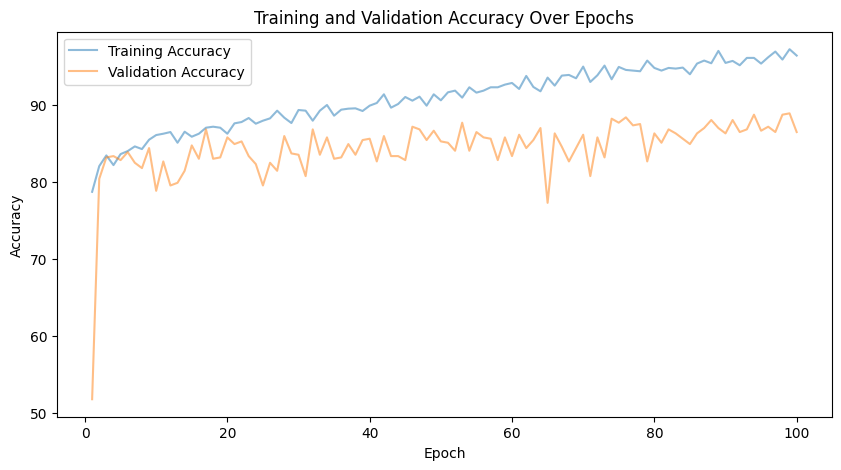

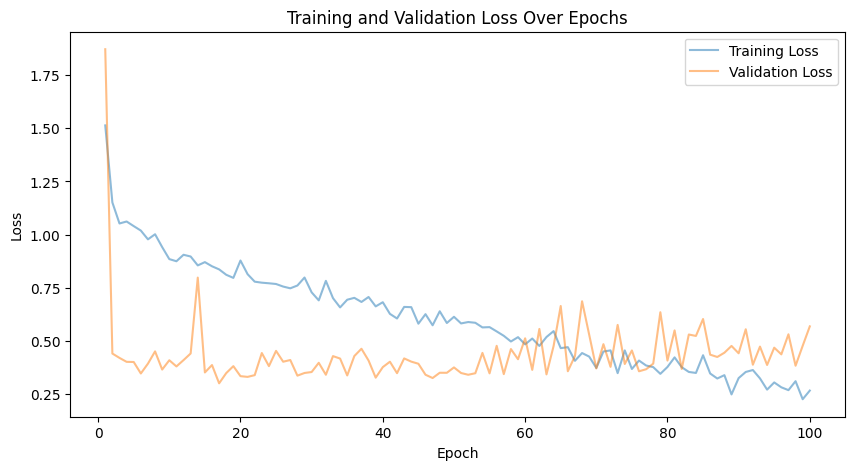

In [38]:
plot_metric('Accuracy', train_acc, val_acc, epochs=model3_num_epochs)
plot_metric('Loss', train_loss, val_loss, epochs=model3_num_epochs)

In [39]:
test_loss, test_acc, y_true, y_probs = eval_model(gn_model, criterion, gn_dataset, gn_test_loader, 'test')
print(f'test loss = {test_loss}')
print(f'test acc = {test_acc}')

Validation: 100%|██████████| 12/12 [00:03<00:00,  3.52batch/s, accuracy=87.5, loss=0.18]

test loss = 0.3857668600976467
test acc = 87.5


[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0,

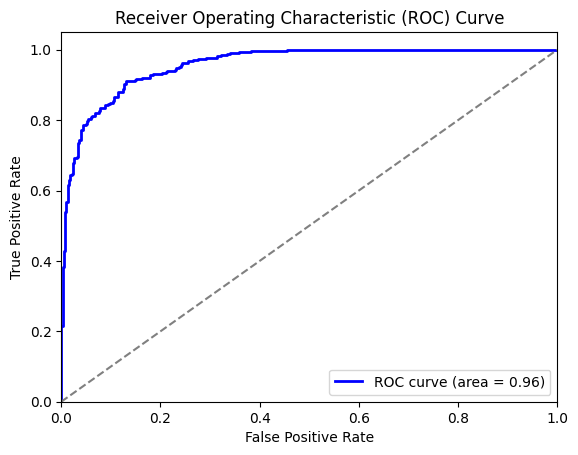

In [40]:
plot_roc_curve(y_true, y_probs)